In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters

num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
# dataset들이 [0, 1] 범위의 이미지
# dataset들을 [-1, 1] 범위로 정규화

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [15]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([4, 3, 32, 32])


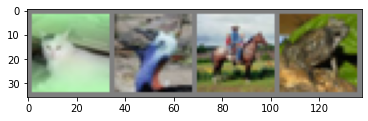

In [10]:
# show images
imshow(torchvision.utils.make_grid(images))

In [44]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   #-> n, 6 ,14, 14
        x = self.pool(F.relu(self.conv2(x)))   #-> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)             #-> n, 400
        x = F.relu(self.fc1(x))                #-> n, 120   
        x = F.relu(self.fc2(x))                #-> n, 84
        x = self.fc3(x)                        #-> n, 10
        return x
    
model = ConvNet().to(device)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [46]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.3075
Epoch [1/5], Step [4000/12500], Loss: 2.3035
Epoch [1/5], Step [6000/12500], Loss: 2.2913
Epoch [1/5], Step [8000/12500], Loss: 2.2656
Epoch [1/5], Step [10000/12500], Loss: 2.2807
Epoch [1/5], Step [12000/12500], Loss: 2.1764
Epoch [2/5], Step [2000/12500], Loss: 2.0539
Epoch [2/5], Step [4000/12500], Loss: 1.7861
Epoch [2/5], Step [6000/12500], Loss: 2.2413
Epoch [2/5], Step [8000/12500], Loss: 2.0365
Epoch [2/5], Step [10000/12500], Loss: 1.1821
Epoch [2/5], Step [12000/12500], Loss: 1.6334
Epoch [3/5], Step [2000/12500], Loss: 1.8052
Epoch [3/5], Step [4000/12500], Loss: 2.0749
Epoch [3/5], Step [6000/12500], Loss: 1.8054
Epoch [3/5], Step [8000/12500], Loss: 1.3006
Epoch [3/5], Step [10000/12500], Loss: 1.3904
Epoch [3/5], Step [12000/12500], Loss: 1.1610
Epoch [4/5], Step [2000/12500], Loss: 0.6693
Epoch [4/5], Step [4000/12500], Loss: 1.2988
Epoch [4/5], Step [6000/12500], Loss: 1.5237
Epoch [4/5], Step [8000/12500], Loss: 0.7867
Epoc

In [47]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 50.204 %
Accuracy of plane: 47.7 %
Accuracy of car: 66.26 %
Accuracy of bird: 32.26 %
Accuracy of cat: 35.04 %
Accuracy of deer: 22.72 %
Accuracy of dog: 43.18 %
Accuracy of frog: 72.96 %
Accuracy of horse: 52.12 %
Accuracy of ship: 63.32 %
Accuracy of truck: 66.48 %


```
Accuracy of the network: 49.572 %
Accuracy of plane: 60.94 %
Accuracy of car: 67.34 %
Accuracy of bird: 40.82 %
Accuracy of cat: 39.04 %
Accuracy of deer: 37.64 %
Accuracy of dog: 26.56 %
Accuracy of frog: 71.68 %
Accuracy of horse: 38.14 %
Accuracy of ship: 63.34 %
Accuracy of truck: 50.22 %
````